In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Retrived calculated expected returns and ADs
all_dfs = {}
all_keys_list = pd.read_csv('Data/all_keys_df.csv')['key'].values.tolist()

for key in all_keys_list:
    all_dfs[key] = pd.read_csv(f"Data/{key}.csv")
    all_dfs[key]['Date'] = pd.to_datetime(all_dfs[key]['Date'])
    all_dfs[key].set_index('Date',inplace = True)

In [3]:
monthly_returns_df = pd.read_csv('Data/monthly_return.csv')
monthly_returns_df = monthly_returns_df.set_index('Date')

In [4]:
def equal_weighted_strategy(monthly_returns):
    """
    Create an equally weighted investment portfolio and plot its performance.

    Parameters:
        *return_arrays: Variable number of arrays representing returns of individual assets.

    Returns:
        A matplotlib graph showing the portfolio performance.
    """
    num_assets = monthly_returns_df.shape[1]  
    weights = np.full((monthly_returns.shape[0], num_assets + 1), 1 / num_assets)  # Equally weighted across assets
    weights[:, -1] = 0  # Set cash weights to 0 (last column for cash)

    # portfolio_returns = np.sum(monthly_returns * weights[:, :-1], axis=1)

    return weights

In [5]:
def min_variance_strategy(monthly_returns_df, window_size=24):
    """
    Create a mean-variance optimized investment portfolio with rolling window covariance matrix
    using scipy.optimize.minimize for optimization.

    Parameters:
        monthly_returns_df (pd.DataFrame): DataFrame where each column represents an asset's monthly returns.
        window_size (int): Rolling window size for calculating covariance matrix (default: 24 for 2 years of monthly returns).

    Returns:
        portfolio_returns (np.ndarray): Portfolio returns over time.
        weights_matrix (np.ndarray): Portfolio weights over time.
    """
    # Initialize variables
    # portfolio_returns = []
    weights_matrix = []
    num_assets = monthly_returns_df.shape[1]

    # Define the objective function (portfolio variance)
    def objective(weights, cov_matrix):
        return weights.T @ cov_matrix @ weights

    # Define constraints and bounds
    def constraint(weights):
        return np.sum(weights) - 1  # Sum of weights must be 1

    bounds = [(0, 1) for _ in range(num_assets)]  # No short selling, weights between 0 and 1
    constraints = {'type': 'eq', 'fun': constraint}

    # Rolling window optimization
    for start in range(len(monthly_returns_df) - window_size):
        # Select the rolling window data
        rolling_data = monthly_returns_df.iloc[start:start + window_size]

        # Calculate covariance matrix of returns within the window
        cov_matrix = rolling_data.cov().values

        # Initial guess for weights (equal weights)
        initial_weights = np.ones(num_assets) / num_assets

        # Perform optimization
        result = minimize(
            fun=objective,
            x0=initial_weights,
            args=(cov_matrix,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        # Get optimized weights
        if result.success:
            weights = result.x
        else:
            weights = initial_weights  # Use equal weights if optimization fails

        # Add cash column weight as 0 (for compatibility with calculate_portfolio_value)
        weights = np.append(weights, 0)

        # Store weights
        weights_matrix.append(weights)

        # Calculate portfolio return for the next period
        # next_return = monthly_returns_df.iloc[start + window_size].dot(weights[:-1])
        # portfolio_returns.append(next_return)

    # Convert results to NumPy arrays
    # portfolio_returns = np.array(portfolio_returns)
    weights_matrix = np.array(weights_matrix)

    return weights_matrix

In [6]:
def multibangbang_strategy(expected_returns, asset_returns):
    """
    Implements the multi-bang-bang investment strategy.

    Parameters:
        expected_returns (numpy.ndarray): A 2D array where each row corresponds to the expected returns at time t for N risky assets.
        asset_returns (numpy.ndarray): A 2D array where each row corresponds to the actual returns of N risky assets at time t.

    Returns:
        numpy.ndarray: Portfolio cumulative performance over time.
    """
    if isinstance(expected_returns, pd.DataFrame):
        expected_returns = expected_returns.to_numpy()
    if isinstance(asset_returns, pd.DataFrame):
        asset_returns = asset_returns.to_numpy()
        
    # Initialize variables
    num_periods = 106
    num_assets = 8
    weights_matrix = np.zeros((num_periods, num_assets + 1))  
    # portfolio_returns = [] 

    # Loop through each time period
    for t in range(num_periods):
        # Find the asset with the highest positive expected return
        mt = expected_returns[t]
        imax = np.argmax(mt)
        # print(imax)

        # Initialize weights for risky assets
        if mt[imax] > 0:
            weights_matrix[t, imax] = 1  # Invest all in the asset with the highest positive return
        else:
            weights_matrix[t, -1] = 1  # Fully invest in cash if no positive expected return

        # Calculate the portfolio return for the period
        # portfolio_return = np.sum(weights_matrix[t, :-1] * asset_returns[t])
        # portfolio_returns.append(portfolio_return) 


    return weights_matrix

## Data Preparing

In [7]:
# Select relevant columns from monthly_returns_df
monthly_returns_df = monthly_returns_df[['USE', 'UST', 'USR', 'GC', 'BC', 'TSE', 'USB', 'BB']]
monthly = monthly_returns_df[['USE', 'UST', 'USR', 'GC', 'BC', 'TSE', 'USB', 'BB']].iloc[-106:]

# Create a dictionary for merged SMSV DataFrames
SMSV_EMA = {f'EMA{i}': pd.merge(all_dfs[f'SMSV_EMA{i}_df'], all_dfs['CMSV_df'], on='Date') for i in range(1, 10)}
for key in SMSV_EMA:
    SMSV_EMA[key] = SMSV_EMA[key].iloc[-106:]
SMSV_EMASO = pd.merge(all_dfs['SMSV_EMASO_df'], all_dfs['CMSV_df'], on='Date')
SMSV_EMASO = SMSV_EMASO.iloc[-106:]

# Create dictionaries for AD_1, AD_2, and AD_3
def create_ad_dict(df, suffix):
    ad_dict = {
        f'EMA{i}': df[[f'USE_SMSV_EMA{i}_{suffix}',  f'UST_SMSV_EMA{i}_{suffix}',
                        f'USR_SMSV_EMA{i}_{suffix}', f'GC_SMSV_EMA{i}_{suffix}',
                       f'BC_SMSV_EMA{i}_{suffix}', f'TSE_SMSV_EMA{i}_{suffix}', 'USB_CMSV_' + suffix, 'BB_CMSV_' + suffix]]
        for i in range(1, 10)
    }
    # Drop the last row for each DataFrame
    for key in ad_dict:
        ad_dict[key] = ad_dict[key].iloc[:-1]

    return ad_dict

AD_1 = create_ad_dict(all_dfs['AD1_df'], 'AD1')
AD_2 = create_ad_dict(all_dfs['AD2_df'], 'AD2')
AD_3 = create_ad_dict(all_dfs['AD3_df'], 'AD3')

# Add EMASO to each AD dictionary
AD_1_EMASO = all_dfs['AD1_df'][['USE_SMSV_EMASO_AD1',  'UST_SMSV_EMASO_AD1', 
                                    'USR_SMSV_EMASO_AD1', 'GC_SMSV_EMASO_AD1', 'BC_SMSV_EMASO_AD1', 'TSE_SMSV_EMASO_AD1',
                                    'USB_CMSV_AD1', 'BB_CMSV_AD1']]
AD_2_EMASO = all_dfs['AD2_df'][['USE_SMSV_EMASO_AD2',  'UST_SMSV_EMASO_AD2', 
                                    'USR_SMSV_EMASO_AD2', 'GC_SMSV_EMASO_AD2', 'BC_SMSV_EMASO_AD2', 'TSE_SMSV_EMASO_AD2',
                                    'USB_CMSV_AD2', 'BB_CMSV_AD2']]
AD_3_EMASO = all_dfs['AD3_df'][['USE_SMSV_EMASO_AD3', 'UST_SMSV_EMASO_AD3', 
                                    'USR_SMSV_EMASO_AD3', 'GC_SMSV_EMASO_AD3', 'BC_SMSV_EMASO_AD3', 'TSE_SMSV_EMASO_AD3',
                                    'USB_CMSV_AD3', 'BB_CMSV_AD3']]
AD_1_EMASO = AD_1_EMASO.iloc[:-1]
AD_2_EMASO = AD_2_EMASO.iloc[:-1]
AD_3_EMASO = AD_3_EMASO.iloc[:-1]

In [8]:
# Function to align columns and multiply AD dictionaries with SMSV
def align_and_multiply(ad_dict, smsv_dict):
    for key in ad_dict.keys():
        ad_dict[key] = 1 - ad_dict[key]
        # Align columns
        ad_dict[key].columns = smsv_dict[key].columns
        ad_dict[key].index = smsv_dict[key].index
        # Element-wise multiplication
        ad_dict[key] = ad_dict[key] * smsv_dict[key] 
        # 0 to na for average calculation 
        ad_dict[key] = ad_dict[key].replace(0, np.nan)

# Align and multiply for AD_1, AD_2, and AD_3
align_and_multiply(AD_1, SMSV_EMA)
align_and_multiply(AD_2, SMSV_EMA)
align_and_multiply(AD_3, SMSV_EMA)

In [9]:
# List of AD_EMASO DataFrames
AD_EMASOs = [AD_1_EMASO, AD_2_EMASO, AD_3_EMASO]
SMSVEMASOs = []

# Simplify operations for all AD_EMASO DataFrames
for i, AD_EMASO in enumerate(AD_EMASOs, start=1):
    # Subtract from 1 and align columns
    AD_EMASO = 1 - AD_EMASO
    AD_EMASO.columns = SMSV_EMASO.columns
    AD_EMASO.index = SMSV_EMASO.index

    
    # Multiply with SMSV_EMASO
    SMSVEMASO = SMSV_EMASO * AD_EMASO
    SMSVEMASOs.append(SMSVEMASO)
    
    # Dynamically assign the resulting DataFrame to a variable
    globals()[f'SMSVEMASO_AD{i}'] = SMSVEMASO

## Average for EMA1-9

In [10]:
# Function to clean column names in AD_1
def average(ad_dict):
    # Select EMA1 to EMA9
    ema_keys = [f'EMA{i}' for i in range(1, 10)]
    
    for key in ema_keys:
        # Rename columns to keep only the part before the first '_'
        ad_dict[key].columns = ad_dict[key].columns.str.split('_').str[0]
    mean_df = pd.concat([ad_dict[key] for key in ema_keys], axis=0).groupby(level=0).mean()
    
    return mean_df

In [11]:
mean_AD1 = average(AD_1)
mean_AD2 = average(AD_2)
mean_AD3 = average(AD_3)

## Get Result from Strategy

In [12]:
weight_SMSVEMASO_AD1 = multibangbang_strategy(SMSVEMASO_AD1, monthly)
weight_SMSVEMASO_AD2 = multibangbang_strategy(SMSVEMASO_AD2, monthly)
weight_SMSVEMASO_AD3 = multibangbang_strategy(SMSVEMASO_AD3, monthly)

In [13]:
weight_SMSVEMA_AD1 = multibangbang_strategy(mean_AD1, monthly)
weight_SMSVEMA_AD2 = multibangbang_strategy(mean_AD2, monthly)
weight_SMSVEMA_AD3 = multibangbang_strategy(mean_AD3, monthly)

In [14]:
weight_MV = min_variance_strategy(monthly_returns_df, window_size=24)
weight_MV = weight_MV[-106:]

In [15]:
weight_EW = equal_weighted_strategy(monthly)

## Portfolio Value

In [16]:
def calculate_portfolio_value(returns, weights, transaction_cost_rate=0.001, initial_value=1):
    """
    Calculate portfolio value considering transaction costs.

    Parameters:
        returns (np.ndarray): A 2D array of shape (T, N) representing returns for N assets over T time steps.
        weights (np.ndarray): A 2D array of shape (T, N+1) representing portfolio weights (N risky assets + 1 cash) at each time step.
        transaction_cost_rate (float): Transaction cost rate (ci), default is 0.001 (10 bps or 0.1%).
        initial_value (float): Initial portfolio value V0, default is 1.

    Returns:
        np.ndarray: An array representing the portfolio value at each time step.
    """
    T, N = returns.shape
    portfolio_value = np.zeros(T + 1)
    portfolio_value[0] = initial_value  # Initial portfolio value

    for t in range(T):
        # Calculate transaction costs at time t
        if t == 0:
            previous_weights = np.zeros(N + 1)  # Initial weights are zero for all assets
        else:
            previous_weights = weights[t - 1]

        current_weights = weights[t]
        current_returns = returns.iloc[t]

        # Include cash 
        extended_returns = np.append(current_returns, 3)

        # Transaction cost: ci * |ω_t - ω_t-1 * V_t-1 * (1 + y_t)|
        transaction_costs = transaction_cost_rate * np.sum(
            np.abs(
                current_weights * portfolio_value[t]
                - previous_weights * portfolio_value[t] * (1 + extended_returns)
            )
        )
        # Update portfolio value: V_t+1 = V_t * (1 + ω_t' * y_t) - TC_t
        portfolio_value[t + 1] = (
            portfolio_value[t] * (1 + np.dot(current_weights, extended_returns)*0.01)
            - transaction_costs
        )
        # print('weight',current_weights)
        # print('return', extended_returns)
        # print('tc',transaction_costs)
        # print('pv',(1 + np.dot(current_weights, extended_returns)*0.01))
        

    return portfolio_value[1:]  # Return portfolio values excluding the initial value

## Graphs

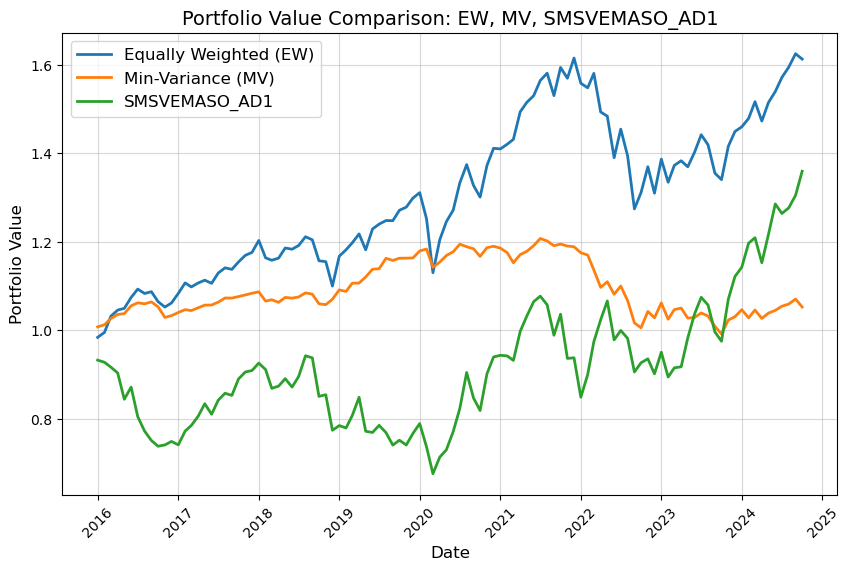

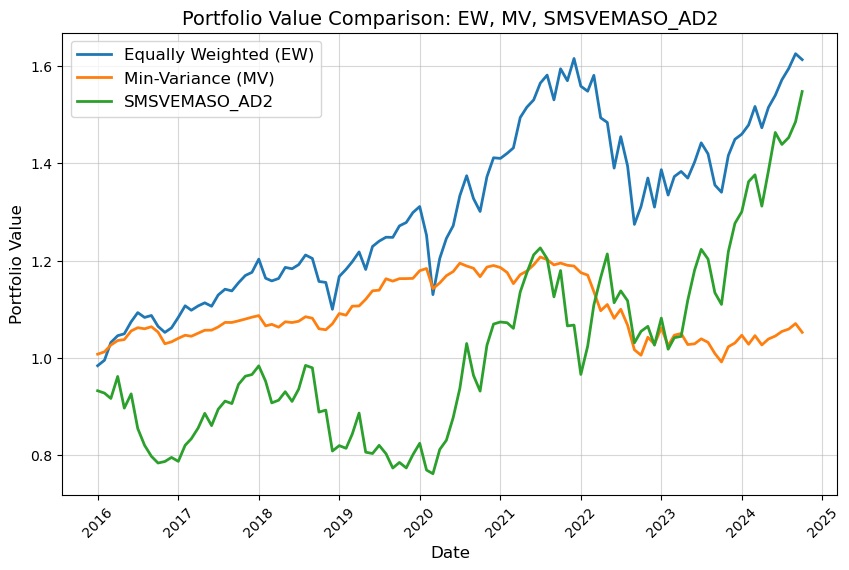

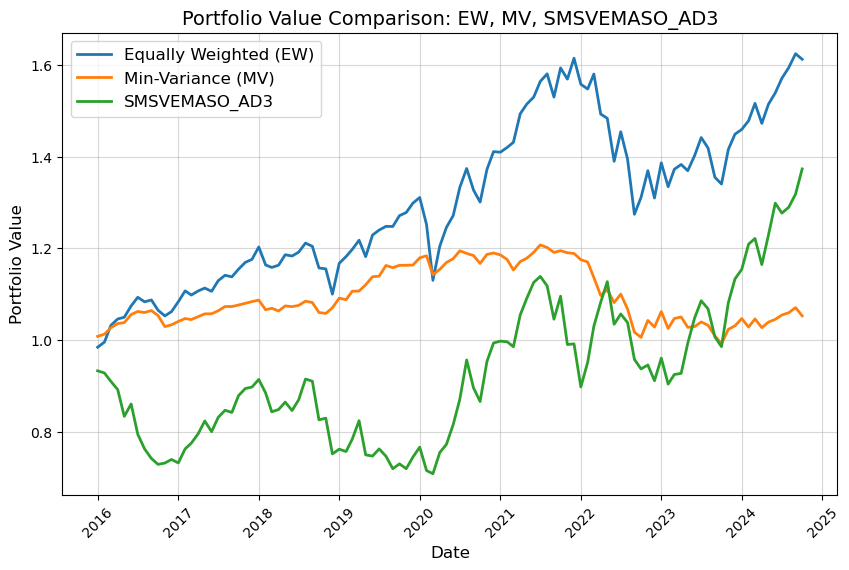

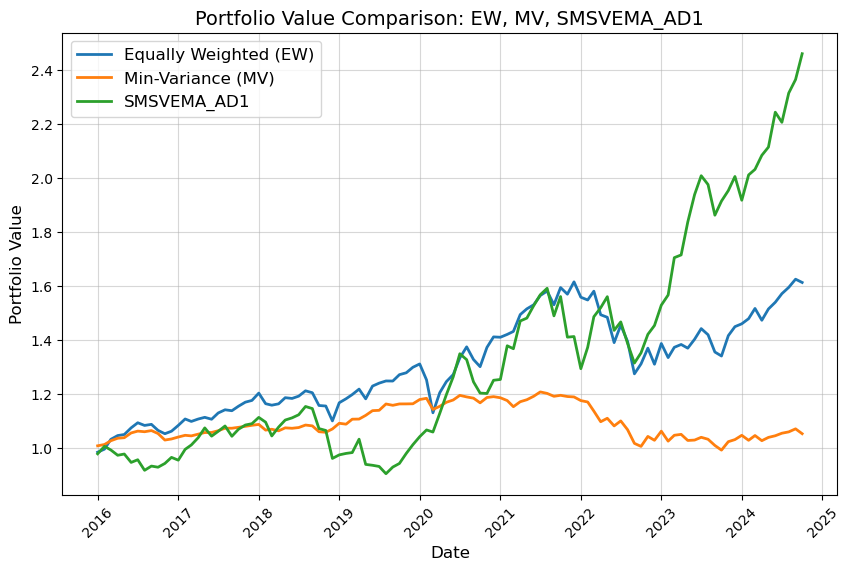

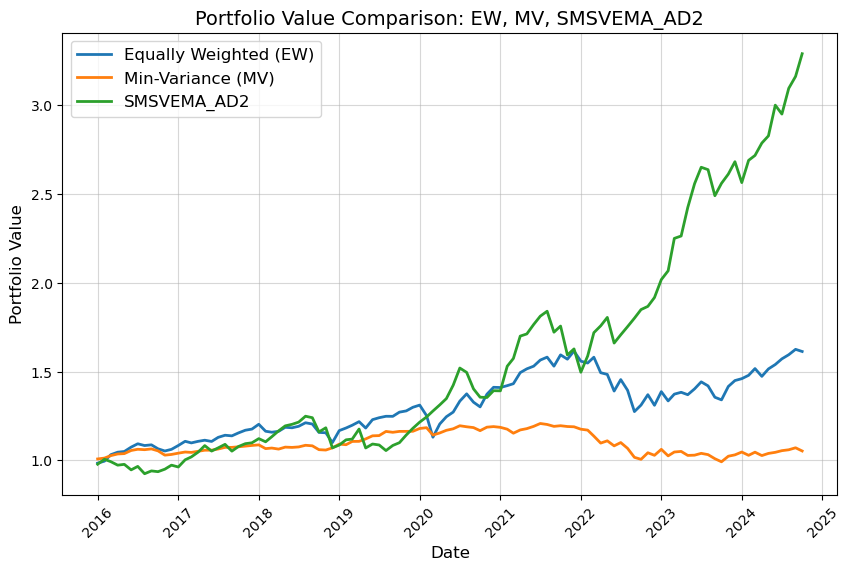

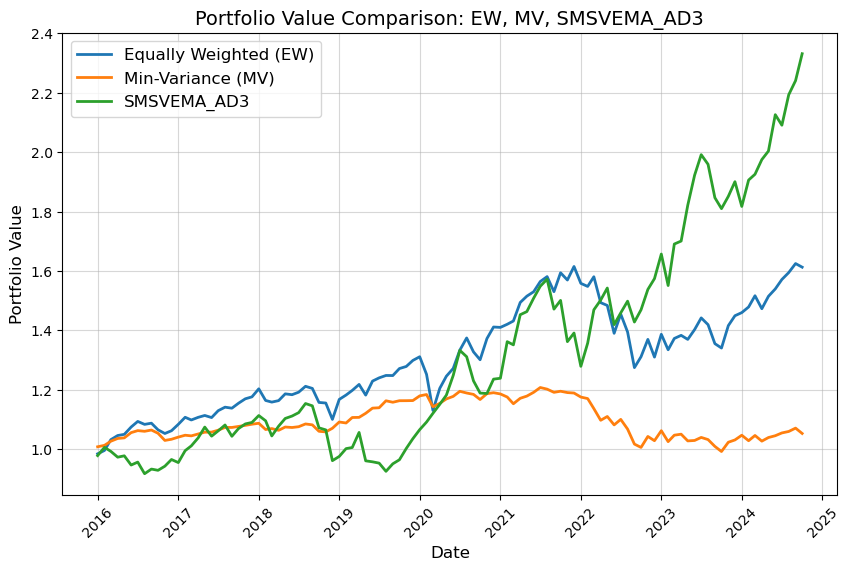

In [18]:

dates = pd.date_range(start="2016-01-01", end="2024-10-01", freq="MS")  # Monthly start frequency

# Portfolio names and weights for SMSV strategies
smsv_strategies = {
    "SMSVEMASO_AD1": weight_SMSVEMASO_AD1,
    "SMSVEMASO_AD2": weight_SMSVEMASO_AD2,
    "SMSVEMASO_AD3": weight_SMSVEMASO_AD3,
    "SMSVEMA_AD1": weight_SMSVEMA_AD1,
    "SMSVEMA_AD2": weight_SMSVEMA_AD2,
    "SMSVEMA_AD3": weight_SMSVEMA_AD3,
}

# Calculate portfolio values
PV_EW = calculate_portfolio_value(monthly, weight_EW)
PV_MV = calculate_portfolio_value(monthly, weight_MV)

portfolio_values = {name: calculate_portfolio_value(monthly, weights) for name, weights in smsv_strategies.items()}

# Plot each graph
for i, (name, PV_SMSV) in enumerate(portfolio_values.items(), start=1):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, PV_EW, label="Equally Weighted (EW)", linewidth=2)
    plt.plot(dates, PV_MV, label="Min-Variance (MV)", linewidth=2)
    plt.plot(dates, PV_SMSV, label=f"{name}", linewidth=2)
    
    plt.title(f"Portfolio Value Comparison: EW, MV, {name}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value", fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

## Evaluation

In [19]:
from EvaluationMetrics import Calculate_Evaluation_metric

In [20]:
def calculate_portfolio_returns(portfolio_values):
    """
    Calculate portfolio returns from a 1D array of portfolio values.

    Parameters:
        portfolio_values (numpy.ndarray): A 1D array representing portfolio values over time.

    Returns:
        numpy.ndarray: A 1D array representing portfolio returns over time.
    """
    # Calculate returns: R_t+1 = V_t+1 / V_t - 1
    portfolio_returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    return portfolio_returns

In [21]:
PR_EW = calculate_portfolio_returns(PV_EW)
PR_MV = calculate_portfolio_returns(PV_MV)
portfolio_returns = {name: calculate_portfolio_returns(values) for name, values in portfolio_values.items()}
for name, values in portfolio_returns.items():
    globals()[f"PR_{name}"] = values

In [22]:
EM_SMSVEMA_AD2 = Calculate_Evaluation_metric(PR_SMSVEMA_AD2)
EM_EW = Calculate_Evaluation_metric(PR_EW)
EM_MV = Calculate_Evaluation_metric(PR_MV)

In [24]:
data = {
    "Strategy": ["EW", "MV", "SMSVEMA_AD2"],
    **{
        metric: [EM_EW.get(metric, None), EM_MV.get(metric, None), EM_SMSVEMA_AD2.get(metric, None)]
        for metric in EM_EW.keys()
    }
}

df = pd.DataFrame(data)

# Rearrange columns to place "Strategy" first
df = df[["Strategy"] + list(EM_EW.keys())]

# Multiply relevant columns by 100 to convert to percentages
percentage_columns = [
    "Compound Return (CR)", "Standard Deviation (SD)", "Downside Deviation (DD)",
    "Maximum Drawdown (MDD)", "Average Drawdown (ADD)"
]
# df[percentage_columns] = df[percentage_columns] * 100

# Display the DataFrame
df.set_index('Strategy')

,Compound Return (CR),Standard Deviation (SD),Downside Deviation (DD),Sharpe Ratio (ShR),Sortino Ratio (SoR),Maximum Drawdown (MDD),Average Drawdown (ADD)
Strategy,,,,,,,
EW,0.061816,0.102117,0.071766,0.605685,0.861831,0.226306,0.041926
MV,0.006286,0.051322,0.038888,0.122738,0.161981,0.190321,0.048108
SMSVEMA_AD2,0.148030,0.130626,0.085746,1.133127,1.726206,0.195906,0.036140
